In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import time
from torch.optim.lr_scheduler import StepLR

In [5]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [6]:
class Transformer_Encoder(nn.Module):
    def __init__(self, 
                 input_channel_size, 
                 hidden_channel_size, 
                 sequence_length, 
                 num_heads = 4,
                 drop_out = 0.1
                ):
        super(Transformer_Encoder, self).__init__()
        
        self.cov1d = nn.Conv1d(input_channel_size, hidden_channel_size, 2, stride=2, padding=0, padding_mode='zeros')
        # Multihead attention layer
        self.attention = nn.MultiheadAttention(embed_dim=sequence_length, num_heads=num_heads,batch_first=True)
        

        # Feedforward layer
        self.feedforward = nn.Sequential(
            nn.Linear(sequence_length, sequence_length),
            nn.ReLU(),
            nn.Linear(sequence_length, sequence_length)
        )

        # Layer normalization
        self.layer_norm1 = nn.LayerNorm(sequence_length)
        self.layer_norm2 = nn.LayerNorm(sequence_length)

        # Dropout
        self.dropout = nn.Dropout(drop_out)

    def forward(self, x):
        # Multihead attention
        x = self.cov1d(x)

        attn_output, _ = self.attention(x, x, x)


        # Add and normalize
        x = self.layer_norm1(x + self.dropout(attn_output))

        # Feedforward
        ff_output = self.feedforward(x)

        # Add and normalize
        x = self.layer_norm2(x + self.dropout(ff_output))

        return x

In [7]:
class Transformer_Decoder(nn.Module):
    def __init__(self, 
                 input_channel_size, 
                 hidden_channel_size, 
                 sequence_length,
                 num_heads=4,
                 drop_out = 0.1
                ):
        super(Transformer_Decoder, self).__init__()
        
        self.covtrans1d = nn.ConvTranspose1d(input_channel_size, hidden_channel_size, 2, stride=2, padding=0, padding_mode='zeros')
        # Multihead attention layer
        self.attention_1 = nn.MultiheadAttention(embed_dim=sequence_length, num_heads=num_heads,batch_first=True)
#        self.attention_2 = nn.MultiheadAttention(embed_dim=sequence_length, num_heads=num_heads,batch_first=True)
        

        # Feedforward layer
        self.feedforward = nn.Sequential(
            nn.Linear(sequence_length, sequence_length),
            nn.ReLU(),
            nn.Linear(sequence_length, sequence_length)
        )

        # Layer normalization
        self.layer_norm1 = nn.LayerNorm(sequence_length)
#        self.layer_norm2 = nn.LayerNorm(sequence_length)
        self.layer_norm3 = nn.LayerNorm(sequence_length)

        # Dropout
        self.dropout = nn.Dropout(drop_out)

    def forward(self, x):
        # Multihead attention
        
        attn_output, _ = self.attention_1(x, x, x)

        # Add and normalize
        x = self.layer_norm1(x + self.dropout(attn_output))
        
        # add multihead-attention to result from encoder
#        attn_output, _ = self.attention_2(x,encoder_out,encoder_out)
        
        # Add and normalize
#        x = self.layer_norm2(x + self.dropout(attn_output))
        
        # Feedforward
        ff_output = self.feedforward(x)
        
        # Add and normalize
        x = self.layer_norm3(x + self.dropout(ff_output))
        
        x = self.covtrans1d(x)

        return x

In [8]:
class Encoder(nn.Module):
    def __init__(self, 
                 sequence_length=96, 
                 input_channel=2, 
                 embedding_size = 16, 
                 cov1d_size=128,
                 num_heads = 4,
                 drop_out = 0.1
                ):
        super(Encoder, self).__init__()

        self.cov1d = nn.Conv1d(input_channel, cov1d_size, 3, stride=1, padding=1, padding_mode='zeros')
        self.cov1d_1 = nn.Conv1d(cov1d_size, 1, 3, stride=1, padding=1, padding_mode='zeros')
        
        sequence_length = int(sequence_length/2)
        
        
        self.transformer_1 = Transformer_Encoder(cov1d_size, 
                                                 cov1d_size, 
                                                 sequence_length,
                                                 num_heads,
                                                 drop_out)
        
        sequence_length = int(sequence_length/2)
        
        
        self.transformer_2 = Transformer_Encoder(cov1d_size, 
                                                 cov1d_size, 
                                                 sequence_length,
                                                 num_heads,
                                                 drop_out)
        sequence_length = int(sequence_length/2)
        
        
        self.transformer_3 = Transformer_Encoder(cov1d_size, 
                                                 cov1d_size, 
                                                 sequence_length,
                                                 num_heads,
                                                 drop_out)
        
        self.relu_1 = nn.ReLU()


        self.dense = nn.Linear(sequence_length, embedding_size)

    #        self.sd = nn.Linear(32,8)
    #        self.logspike = nn.Linear(32,8)

    def forward(self, x):
        
        out = self.cov1d(x)
        
        enc_trans_1 = self.transformer_1(out)
        
        enc_trans_2 = self.transformer_2(enc_trans_1)
        
        enc_trans_3 = self.transformer_3(enc_trans_2)
        
        out = self.cov1d_1(enc_trans_3)
        
        out = out.squeeze(1)

        out = self.dense(out)
        
        out = self.relu_1(out)
        


        return out, enc_trans_1, enc_trans_2, enc_trans_3


In [9]:
class Decoder(nn.Module):
    def __init__(self, 
                 sequence_length=12, 
                 input_channel=2, 
                 embedding_size = 16, 
                 cov1d_size=128,
                 num_heads = 4,
                 drop_out = 0.1
                ):
        super(Decoder, self).__init__()

        self.cov1d = nn.Conv1d(1, cov1d_size, 3, stride=1, padding=1, padding_mode='zeros')
        self.cov1d_1 = nn.Conv1d(cov1d_size, input_channel, 3, stride=1, padding=1, padding_mode='zeros')
        self.dense = nn.Linear(embedding_size, sequence_length)
        
        
        self.transformer_1 = Transformer_Decoder(cov1d_size, 
                                                 cov1d_size, 
                                                 sequence_length,
                                                 num_heads,
                                                 drop_out)
        
        sequence_length = int(sequence_length*2)
        
        
        self.transformer_2 = Transformer_Decoder(cov1d_size, 
                                                 cov1d_size, 
                                                 sequence_length,
                                                 num_heads,
                                                 drop_out)
        sequence_length = int(sequence_length*2)
        
        
        self.transformer_3 = Transformer_Decoder(cov1d_size, 
                                                 cov1d_size, 
                                                 sequence_length,
                                                 num_heads,
                                                 drop_out)


    def forward(self, x):
#        x = x.transpose(1, 2)
        out = self.dense(x)
    
        out = out.unsqueeze(1)

        out = self.cov1d(out)
        
        out = self.transformer_1(out)
        
        out = self.transformer_2(out)
        
        out = self.transformer_3(out)
        
        out = self.cov1d_1(out)
        


        return out 

In [10]:
class VAE(nn.Module):
    ''' This the VAE, which takes a encoder and decoder.

    '''

    def __init__(self, 
                 enc, 
                 dec, 
                 embedding_size = 16, 
                 num_vae=1,
                 fix_channel = False,
                 set_topK = True,
                 topk = 1,
                 channel_list = [0,1,2,3]
                ):
        super(VAE, self).__init__()

        self.enc = enc
        self.dec = dec
        self.num_vae = num_vae
        self.mn  = nn.Linear(embedding_size, embedding_size)
        self.var = nn.Linear(embedding_size,embedding_size)
        self.relu_1 = nn.ReLU()
        self.fix_channel = fix_channel
        self.channel_list = channel_list
        self.set_topK = set_topK
        self.topk = topk
        if self.num_vae == 2:
            self.mn_after = nn.Linear(embedding_size,embedding_size)
            self.var_after = nn.Linear(embedding_size,embedding_size)
            self.relu_2 = nn.ReLU()
#        self.embedding_layer = nn.Linear(embedding_size,embedding_size)
        
        if self.fix_channel:
            to_zero = [e for e in range(embedding_size) if e not in self.channel_list]
            self.zero_index = torch.tensor(to_zero,dtype = torch.int)
                   
        
    def reparameterize(self, mu, logvar):
        
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        
        return mu + eps*std
    
    
    def specify_channel(self, embed_):
        
        embed_co = torch.clone(embed_)
        embed_co[:,self.zero_index]=0
        
        return embed_co
    
    def set_K(self,embed_):
        
        embed_co = torch.clone(embed_)
        for i in range(embed_.shape[0]):
            to_zero = [e for e in range(embed_.shape[1]) if e not in torch.topk(embed_co[i],self.topk)[1]]
            zero_index = torch.tensor(to_zero,dtype = torch.int)
            embed_co[i,zero_index] = 0
        
        return embed_co
        
        
        

    def forward(self, 
                x,
               ):
        # encode
        encoder_out,enc_trans_1,enc_trans_2,enc_trans_3 = self.enc(x)
        
        # variational layer
        mn_ = self.mn(encoder_out)
        var_ = self.var(encoder_out)
        h1 = self.reparameterize(mn_,var_)
#        pre_embedding = self.embedding_layer(h1)
        embedding = self.relu_1(h1)
        
        
        # another VAE layer
        if self.num_vae == 2:
        # sample from the distribution having latent parameters z_mu, z_var
        # reparameterize
            mn_after = self.mn_after(embedding)
            var_after = self.var_after(embedding)
            h2 = self.reparameterize(mn_after,var_after)
            h2 = self.relu_2(h2)
            if self.fix_channel:
                h2 = self.specify_channel(h2)
            elif self.set_topK:
                h2 = self.set_K(h2)
            # decode
            predicted = self.dec(h2)
            
            return predicted, embedding, mn_,var_, mn_after,var_after, h2
        
        if self.fix_channel:
            
            embedding = self.specify_channel(embedding)
            
        elif self.set_topK:
            embedding = self.set_K(embedding)
            
        
        predicted = self.dec(embedding)
        
        return predicted, embedding, mn_, var_

In [11]:
def rand_tensor(min=0, max=1, size=(1)):
    out = (max - min) * torch.rand(size) + min
    return out

In [106]:
class Polynomial_func:
    def __init__(self, x, range=[-1,1], degree = 3, size=(1,1), sample_size=100, device="cuda"):
        self.x = x
        self.range = range
        self.degree = degree
        self.size = size
        self.sample_size = sample_size
        self.device = device

    def generate(self):
        hold = []
        for n in range(self.degree + 1):
            p = rand_tensor(
                min=self.range[0],
                max=self.range[1],
                size=(self.sample_size, self.size[0], self.size[1]),
            )
            hold.append(p)
        params = torch.stack(hold)
        params = torch.atleast_2d(params)
        params = torch.transpose(params, 0, 1)
        params = torch.transpose(params, 1, 2)
        params = params.to(self.device)

        x = (
            torch.cat(params.shape[0] * [self.x])
            .reshape(params.shape[0], -1)
            .to(self.device)
        )
        x = torch.transpose(x, 0, 1).to(self.device)
        y = torch.zeros_like(x)

        for d in range(self.degree+1):
            coeffs = params[:,0,d,0]
            y += coeffs*(x**d)
        out = torch.zeros(
                (params.shape[0], self.x.shape[0],
                self.size[0], self.size[1])
            ).to(self.device)            
        out[:,:,0,0] = torch.transpose(y,0,1)
        return torch.sum(out,dim=3)


In [13]:
def linear_function(params, x, device):
    x = x.to(device)
    if params.size(1) > 1:
        a = params[:, 0].type(torch.float).unsqueeze(1).to(device)
        b = params[:, 1].type(torch.float).unsqueeze(1).to(device)
        return a*x + b
    else:
        return torch.zeros_like(params)

def quadratic_function(params, x, device):
    params = params.to(device)
    x = x.to(device)
    y = torch.zeros((params.size(0),x.shape[0])).to(device)
    if params.size(1) > 2:
        for n in range(len(params[0])):
            y += (params[:, n].type(torch.float).unsqueeze(1).to(device))*x**(3-n)
        return y
    else:
        return torch.zeros_like(params)

In [107]:
sample_size = 1000
sequence_length = 100
batch_size = 50
data_range = [-1, 1]
num_funcs = 2

x_values = torch.linspace(data_range[0], data_range[1], sequence_length)

linear = Polynomial_func(x=x_values, range=data_range, degree=1, sample_size=sample_size, device=device)
lin_full = linear.generate()

quad = Polynomial_func(x=x_values, range=data_range, degree=2, sample_size=sample_size, device=device)
quad_full = quad.generate()

all_data = DataLoader(torch.vstack([quad_full, lin_full]), batch_size=batch_size, shuffle=True)

In [15]:
def new_loss(output, target, x):
    x = x.clone().detach().requires_grad_(True)
    target = target.clone().detach().requires_grad_(True)
    derivative_true = torch.autograd.grad(outputs=target, inputs=x, grad_outputs=torch.ones_like(target), allow_unused=True)[0]
    if derivative_true is None:
        derivative_true = torch.zeros_like(output)
    derivative_pred = (torch.roll(output, shifts=-1, dims=0) - torch.roll(output, shifts=1, dims=0)) / (2 * 1e-8)
    mse_function = torch.mean(torch.abs(target - output)**3)
    mse_derivative = torch.mean(torch.abs(derivative_pred - derivative_true)**3)
    return mse_function + mse_derivative


In [260]:
class Multi_Func(nn.Module):
    def __init__(self, functions, x_data, input_channels, transformer, device):
        super().__init__()
        self.device = device
        self.functions = functions
        self.x_data = x_data
        self.input_channels = input_channels
        self.params = sum(self.functions[1])
        self.transformer = transformer

        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.input_channels, out_channels=8, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8, out_channels=6, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(64)
        )

        self.hidden_xfc = nn.Sequential(
            nn.Linear(256, 64),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.SELU(),
            nn.Linear(32, 20),
            nn.SELU(),
        )

        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(16),
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(8),
            nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(96),
        )

        self.flatten_layer = nn.Flatten()

        self.hidden_embedding = nn.Sequential(
            nn.Linear(212, 128),
            nn.SELU(),
            nn.Linear(128, 64),
            nn.SELU(),
            nn.Linear(64, self.params),
        )

    def forward(self, x, n=-1):
        target = x.squeeze(dim=2)

        x = torch.swapaxes(x, 1, 2).to(self.device)
        x, _, _, _ = self.transformer(x)

        x = self.hidden_x1(x)
        xfc = torch.reshape(x, (n, 256))
        xfc = self.hidden_xfc(xfc)

        x = torch.reshape(x, (n, 2, 128))
        x = self.hidden_x2(x)

        cnn_flat = self.flatten_layer(x)
        encoded = torch.cat((cnn_flat, xfc), dim=1)
        embedding = self.hidden_embedding(encoded)

        start_index = 0
        losses = []
        outputs = []

        for f in range(len(self.functions[0])):
            output = self.functions[0][f](
                embedding[:, start_index:start_index + self.functions[1][f]], 
                self.x_data, 
                device=self.device
            ).to(self.device)
            outputs.append(output)
            loss = new_loss(output, target, x)
            losses.append(loss)
            start_index += self.functions[1][f]

        outputs = torch.stack(outputs)
        losses = torch.stack(losses)
        best_index = torch.argmin(losses)
        best_loss, best_out = losses[best_index], outputs[best_index]
        
        return best_out, best_loss, outputs, losses


In [17]:
def build_model(device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                sequence_length_encoder= 96, 
                sequence_length_decoder = 12,
                input_channel=2, 
                embedding_size = 16, 
                cov1d_size=128,
                num_heads = 4,
                drop_out = 0.1,
                learning_rate = 3e-5,
                num_vae = 1,
                fix_channel = False,
                set_topK = True,
                topk = 2,
                channel_list = None
                ):
    
    encoder = Encoder(sequence_length=sequence_length_encoder, 
                      input_channel=input_channel, 
                      embedding_size = embedding_size, 
                      cov1d_size=cov1d_size,
                      num_heads = num_heads,
                      drop_out = drop_out
                        ).to(device)
    
    decoder = Decoder(sequence_length=sequence_length_decoder, 
                      input_channel=input_channel, 
                      embedding_size = embedding_size, 
                      cov1d_size=cov1d_size,
                      num_heads = num_heads,
                      drop_out = drop_out
                     ).to(device)
    
    vae = VAE(encoder,
              decoder,
              embedding_size = embedding_size,
              num_vae = num_vae,
              fix_channel = fix_channel,
              set_topK = set_topK,
              topk = topk,
              channel_list = channel_list).to(device)
    
    optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
    
    return vae, encoder, decoder, optimizer
    

In [317]:
transformer, encoder, decoder, optimizer = build_model(
    sequence_length_encoder=sequence_length,
    sequence_length_decoder=16,
    input_channel=1,
    embedding_size=16,
    cov1d_size=128,
    num_heads=sequence_length/10,
    learning_rate=0.001
)

    # sequence_length_encoder=64,
    #sequence_length_decoder=16,
    #input_channel=2,
    #embedding_size=16,
    #cov1d_size=128,
    #num_heads=1

AssertionError: embed_dim must be divisible by num_heads

In [ ]:
'''sequence_length_encoder= 96, 
                sequence_length_decoder = 12,
                input_channel=2, 
                embedding_size = 16, 
                cov1d_size=128,
                num_heads = 4,
                drop_out = 0.1,
                learning_rate = 3e-5,
                num_vae = 1,
                fix_channel = False,
                set_topK = True,
                topk = 2,
                channel_list = None'''

In [318]:
model = Multi_Func(functions=[[linear_function, quadratic_function],[2,3]], x_data=x_values, input_channels=1, transformer=transformer, device=device).to(device)
loss_func = nn.MSELoss()
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [319]:
epochs = 20
for epoch in range(epochs):
    start_time = time.time()
    train_loss = 0.0
    total_num = 0
    model.train()
    
    for train_batch in all_data:
        train_batch = train_batch.to(device)
        target_batch = train_batch.squeeze(2).to(device)
        optimizer.zero_grad()
        best_out,_,_,_ = model(train_batch)
        loss = loss_func(best_out,target_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * best_out.shape[0]
        total_num += best_out.shape[0]
    scheduler.step()
    train_loss /= total_num
    print(f"epoch : {epoch}/{epochs}, loss = {train_loss:.8f}")
    print(f"--- {time.time() - start_time} seconds ---")

epoch : 0/20, loss = 0.57536858
--- 3.2550032138824463 seconds ---
epoch : 1/20, loss = 0.40674062
--- 3.2124452590942383 seconds ---
epoch : 2/20, loss = 0.39138499
--- 3.0711216926574707 seconds ---
epoch : 3/20, loss = 0.38512788
--- 3.1656503677368164 seconds ---
epoch : 4/20, loss = 0.35064402
--- 3.1270952224731445 seconds ---
epoch : 5/20, loss = 0.33964737
--- 3.0097591876983643 seconds ---
epoch : 6/20, loss = 0.31081852
--- 3.1394801139831543 seconds ---
epoch : 7/20, loss = 0.29309857
--- 3.143803358078003 seconds ---
epoch : 8/20, loss = 0.28606998
--- 3.034482479095459 seconds ---
epoch : 9/20, loss = 0.29042843
--- 3.1269164085388184 seconds ---
epoch : 10/20, loss = 0.28304868
--- 3.2351672649383545 seconds ---
epoch : 11/20, loss = 0.27314179
--- 3.1502151489257812 seconds ---
epoch : 12/20, loss = 0.26378138
--- 3.0508413314819336 seconds ---
epoch : 13/20, loss = 0.29373921
--- 3.148566246032715 seconds ---
epoch : 14/20, loss = 0.27281673
--- 3.1730263233184814 secon

In [108]:
t_sample_size = 100

t_x_values = torch.linspace(-1, 1, 1000)
t_linear = Polynomial_func(x=x_values, range=[-1,1], degree=1, sample_size=t_sample_size, device=device)
t_quad = Polynomial_func(x=x_values, range=[-1,1], degree=2, sample_size=t_sample_size, device=device)

t_lin_full = t_linear.generate()
t_quad_full = t_quad.generate()


t_data = torch.vstack([t_lin_full, t_quad_full])

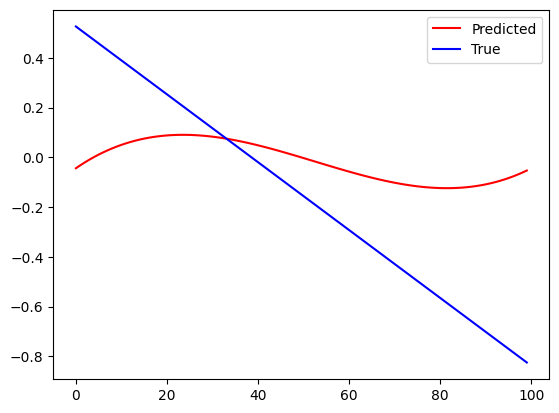

In [322]:
model.eval
best_out, best_loss, outputs, losses = model(t_data)
rand = np.random.randint(0, t_sample_size*num_funcs)
plt.plot(best_out[rand].detach().cpu().numpy(), "r", label='Predicted')
plt.plot(t_data[rand].detach().cpu().numpy(), "b", label='True')
#plt.plot(outputs[0][rand].detach().cpu().numpy(), "g", label='lin')
#plt.plot(outputs[1][rand].detach().cpu().numpy(), "g", label='quad')
plt.legend();